## Traditional Deep Learning Models (BiLSTM, RNN, CNN)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SimpleRNN, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [8]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

CUDA available: True
Device: NVIDIA GeForce RTX 3050 Laptop GPU


In [10]:
# Load dataset
df = pd.read_csv("English_cleaned.csv")

# Evaluate string representation of trigrams
df['trigrams_token'] = df['trigrams_token'].apply(eval)

# Convert trigrams into string format
df['trigrams_str'] = df['trigrams_token'].apply(lambda x: [' '.join(t) for t in x])
df['joined'] = df['trigrams_str'].apply(lambda x: ' '.join(x))

# Convert -1 labels to 0
df['target'] = df['target'].replace({-1: 0})

# Final features and target
X = df['joined'].values
y = df['target'].values


In [11]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

max_len = max(len(seq) for seq in sequences)
X_pad = pad_sequences(sequences, maxlen=max_len)

In [12]:
# Load GloVe
embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [13]:
# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X_pad, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def build_model(model_type='bilstm', units=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))
    
    if model_type == 'bilstm':
        model.add(Bidirectional(LSTM(units)))
    elif model_type == 'rnn':
        model.add(SimpleRNN(units))
    elif model_type == 'cnn':
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(GlobalMaxPooling1D())
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [17]:
# Training & evaluation
def train_and_evaluate(model_type):
    best_acc = 0
    best_model = None
    best_params = {}

    for units in [32, 64]:
        for dropout in [0.3, 0.5]:
            print(f"\nTraining {model_type.upper()} with {units} units and {dropout} dropout...")
            model = build_model(model_type=model_type, units=units, dropout_rate=dropout)
            checkpoint = ModelCheckpoint(f"{model_type}_best_model.keras", monitor='val_accuracy', save_best_only=True)
            early_stop = EarlyStopping(monitor='val_loss', patience=3)

            history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                                validation_data=(X_val, y_val),
                                callbacks=[checkpoint, early_stop],
                                verbose=1)
            
            val_acc = max(history.history['val_accuracy'])
            if val_acc > best_acc:
                best_acc = val_acc
                best_model = tf.keras.models.load_model(f"{model_type}_best_model.keras")
                best_params = {'units': units, 'dropout': dropout}
            
            # Plot training history
            plt.plot(history.history['accuracy'], label='Train Accuracy')
            plt.plot(history.history['val_accuracy'], label='Val Accuracy')
            plt.title(f"{model_type.upper()} | Units={units} Dropout={dropout}")
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()

    print(f"\n Best {model_type.upper()} Model: {best_params} | Val Accuracy: {best_acc:.4f}")
    
    # Evaluation
    preds = (best_model.predict(X_test) > 0.5).astype(int)
    print("\nClassification Report:\n", classification_report(y_test, preds))
    print("Confusion Matrix:")
    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_type.upper()} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save best model
    best_model.save(f"best_{model_type}_model_final.keras")


Training BILSTM with 32 units and 0.3 dropout...
Epoch 1/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 675s 19ms/step - accuracy: 0.7439 - loss: 0.5151 - val_accuracy: 0.7885 - val_loss: 0.4505
Epoch 2/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 667s 19ms/step - accuracy: 0.7895 - loss: 0.4511 - val_accuracy: 0.7903 - val_loss: 0.4457
Epoch 3/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 651s 19ms/step - accuracy: 0.7969 - loss: 0.4389 - val_accuracy: 0.8013 - val_loss: 0.4294
Epoch 4/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 644s 19ms/step - accuracy: 0.8000 - loss: 0.4332 - val_accuracy: 0.8012 - val_loss: 0.4295
Epoch 5/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 641s 18ms/step - accuracy: 0.8026 - loss: 0.4291 - val_accuracy: 0.8010 - val_loss: 0.4307
Epoch 6/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 653s 19ms/step - accuracy: 0.8049 - loss: 0.4256 - val_accuracy: 0.8015 - val_loss: 0.4278
Epoch 7/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 635s 18ms/step - accuracy: 0.8063 - loss: 0.4220 - val_accuracy: 0.8044 - val_loss: 0.4230
Epoch

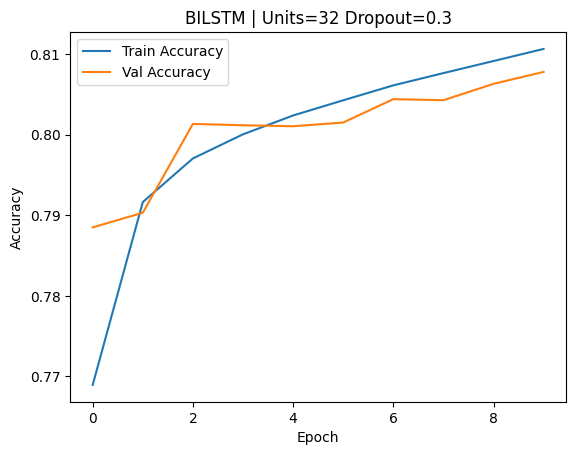


Training BILSTM with 32 units and 0.5 dropout...
Epoch 1/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 634s 18ms/step - accuracy: 0.7406 - loss: 0.5232 - val_accuracy: 0.7885 - val_loss: 0.4521
Epoch 2/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 659s 19ms/step - accuracy: 0.7851 - loss: 0.4610 - val_accuracy: 0.7943 - val_loss: 0.4429
Epoch 3/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 646s 19ms/step - accuracy: 0.7914 - loss: 0.4502 - val_accuracy: 0.7979 - val_loss: 0.4374
Epoch 4/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 668s 19ms/step - accuracy: 0.7956 - loss: 0.4438 - val_accuracy: 0.8001 - val_loss: 0.4324
Epoch 5/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 668s 19ms/step - accuracy: 0.7975 - loss: 0.4391 - val_accuracy: 0.7978 - val_loss: 0.4339
Epoch 6/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 683s 20ms/step - accuracy: 0.7997 - loss: 0.4354 - val_accuracy: 0.8024 - val_loss: 0.4278
Epoch 7/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 651s 19ms/step - accuracy: 0.8029 - loss: 0.4306 - val_accuracy: 0.8042 - val_loss: 0.4256
Epoch

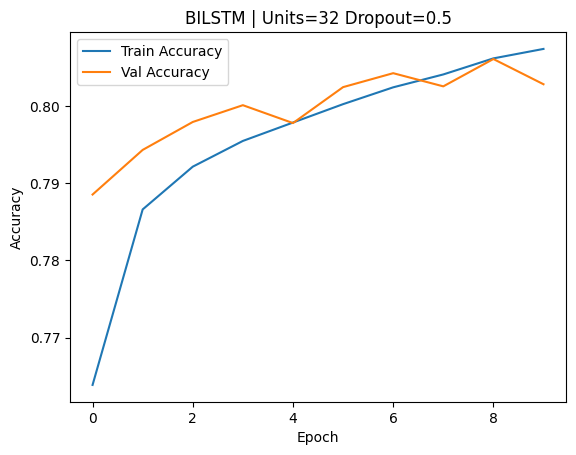


Training BILSTM with 64 units and 0.3 dropout...
Epoch 1/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 796s 23ms/step - accuracy: 0.7521 - loss: 0.5029 - val_accuracy: 0.7948 - val_loss: 0.4397
Epoch 2/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 958s 28ms/step - accuracy: 0.7980 - loss: 0.4353 - val_accuracy: 0.8022 - val_loss: 0.4260
Epoch 3/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 929s 27ms/step - accuracy: 0.8064 - loss: 0.4218 - val_accuracy: 0.8090 - val_loss: 0.4162
Epoch 4/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 1021s 29ms/step - accuracy: 0.8103 - loss: 0.4144 - val_accuracy: 0.8103 - val_loss: 0.4153
Epoch 5/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 944s 27ms/step - accuracy: 0.8133 - loss: 0.4096 - val_accuracy: 0.8109 - val_loss: 0.4132
Epoch 6/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 1033s 30ms/step - accuracy: 0.8156 - loss: 0.4052 - val_accuracy: 0.8106 - val_loss: 0.4147
Epoch 7/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 976s 28ms/step - accuracy: 0.8175 - loss: 0.4016 - val_accuracy: 0.8115 - val_loss: 0.4124
Epo

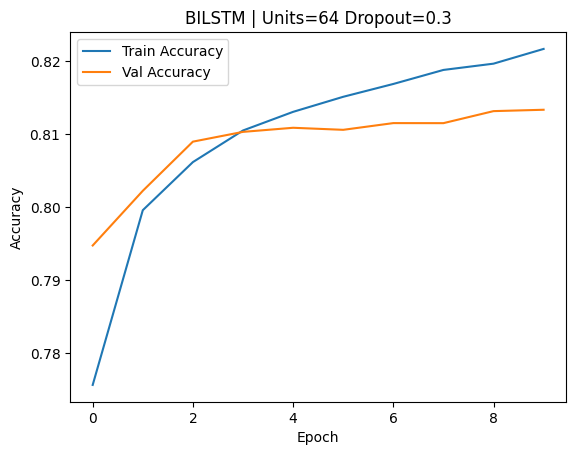


Training BILSTM with 64 units and 0.5 dropout...
Epoch 1/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 1054s 30ms/step - accuracy: 0.7466 - loss: 0.5121 - val_accuracy: 0.7944 - val_loss: 0.4407
Epoch 2/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 1120s 32ms/step - accuracy: 0.7951 - loss: 0.4436 - val_accuracy: 0.8028 - val_loss: 0.4259
Epoch 3/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 1109s 32ms/step - accuracy: 0.8036 - loss: 0.4292 - val_accuracy: 0.8065 - val_loss: 0.4224
Epoch 4/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 1135s 33ms/step - accuracy: 0.8069 - loss: 0.4230 - val_accuracy: 0.8045 - val_loss: 0.4215
Epoch 5/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 1171s 34ms/step - accuracy: 0.8090 - loss: 0.4185 - val_accuracy: 0.8080 - val_loss: 0.4180
Epoch 6/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 1164s 34ms/step - accuracy: 0.8119 - loss: 0.4139 - val_accuracy: 0.8093 - val_loss: 0.4149
Epoch 7/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 1149s 33ms/step - accuracy: 0.8134 - loss: 0.4123 - val_accuracy: 0.8086 - val_loss: 0.415

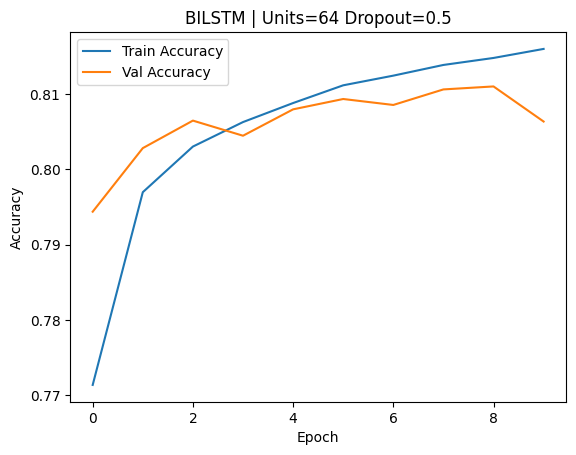


 Best BILSTM Model: {'units': 64, 'dropout': 0.3} | Val Accuracy: 0.8133
4344/4344 ━━━━━━━━━━━━━━━━━━━━ 59s 13ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.81     69829
           1       0.82      0.80      0.81     69158

    accuracy                           0.81    138987
   macro avg       0.81      0.81      0.81    138987
weighted avg       0.81      0.81      0.81    138987

Confusion Matrix:


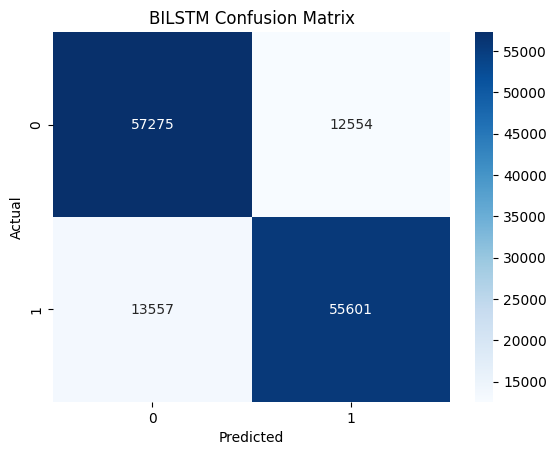


Training RNN with 32 units and 0.3 dropout...


c:\Applications\Social Media Sentiment Analysis\venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 250s 7ms/step - accuracy: 0.6411 - loss: 0.6364 - val_accuracy: 0.6426 - val_loss: 0.6303
Epoch 2/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 279s 8ms/step - accuracy: 0.6629 - loss: 0.6191 - val_accuracy: 0.6643 - val_loss: 0.6121
Epoch 3/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 272s 8ms/step - accuracy: 0.6630 - loss: 0.6173 - val_accuracy: 0.6778 - val_loss: 0.6052
Epoch 4/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 304s 9ms/step - accuracy: 0.6723 - loss: 0.6108 - val_accuracy: 0.6971 - val_loss: 0.5821
Epoch 5/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 308s 9ms/step - accuracy: 0.6836 - loss: 0.5982 - val_accuracy: 0.7055 - val_loss: 0.5797
Epoch 6/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 305s 9ms/step - accuracy: 0.6852 - loss: 0.5988 - val_accuracy: 0.6876 - val_loss: 0.5874
Epoch 7/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 302s 9ms/step - accuracy: 0.6856 - loss: 0.5975 - val_accuracy: 0.6729 - val_loss: 0.6076
Epoch 8/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 295s 8ms/step - ac

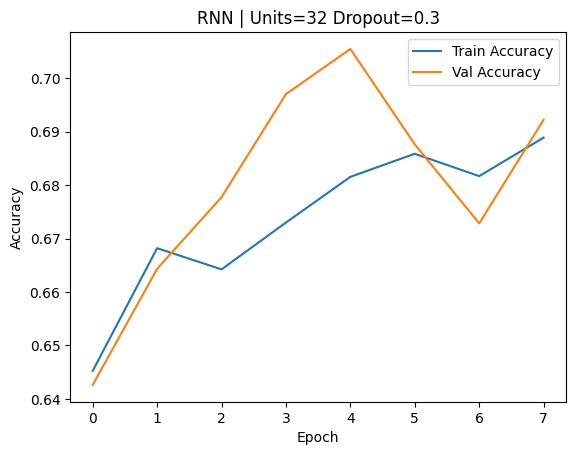


Training RNN with 32 units and 0.5 dropout...
Epoch 1/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 238s 7ms/step - accuracy: 0.6323 - loss: 0.6451 - val_accuracy: 0.6500 - val_loss: 0.6294
Epoch 2/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 272s 8ms/step - accuracy: 0.6472 - loss: 0.6323 - val_accuracy: 0.6447 - val_loss: 0.6324
Epoch 3/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 258s 7ms/step - accuracy: 0.6477 - loss: 0.6320 - val_accuracy: 0.6423 - val_loss: 0.6317
Epoch 4/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 270s 8ms/step - accuracy: 0.6624 - loss: 0.6221 - val_accuracy: 0.6786 - val_loss: 0.6025
Epoch 5/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 256s 7ms/step - accuracy: 0.6548 - loss: 0.6260 - val_accuracy: 0.6895 - val_loss: 0.5998
Epoch 6/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 270s 8ms/step - accuracy: 0.6745 - loss: 0.6116 - val_accuracy: 0.6743 - val_loss: 0.6049
Epoch 7/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 256s 7ms/step - accuracy: 0.6761 - loss: 0.6077 - val_accuracy: 0.6932 - val_loss: 0.5884
Epoch 8/10
3474

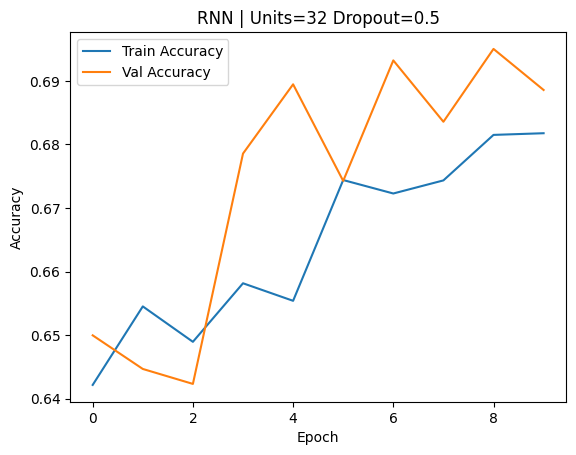


Training RNN with 64 units and 0.3 dropout...
Epoch 1/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 271s 8ms/step - accuracy: 0.6393 - loss: 0.6371 - val_accuracy: 0.6833 - val_loss: 0.6026
Epoch 2/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 309s 9ms/step - accuracy: 0.6673 - loss: 0.6131 - val_accuracy: 0.6591 - val_loss: 0.6191
Epoch 3/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 274s 8ms/step - accuracy: 0.6652 - loss: 0.6150 - val_accuracy: 0.6512 - val_loss: 0.6241
Epoch 4/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 302s 9ms/step - accuracy: 0.6675 - loss: 0.6123 - val_accuracy: 0.6536 - val_loss: 0.6198


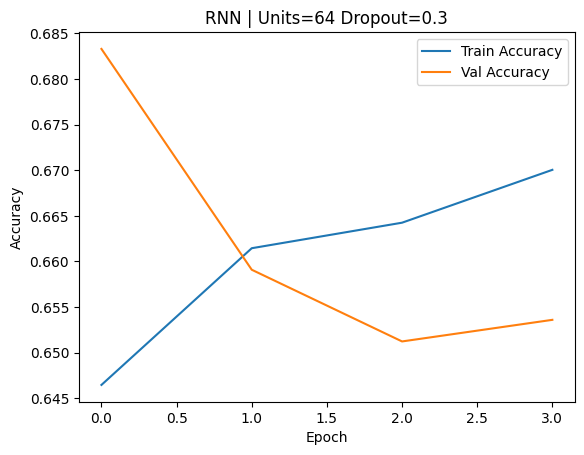


Training RNN with 64 units and 0.5 dropout...
Epoch 1/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 274s 8ms/step - accuracy: 0.6296 - loss: 0.6468 - val_accuracy: 0.6655 - val_loss: 0.6132
Epoch 2/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 312s 9ms/step - accuracy: 0.6476 - loss: 0.6309 - val_accuracy: 0.6696 - val_loss: 0.6134
Epoch 3/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 274s 8ms/step - accuracy: 0.6517 - loss: 0.6292 - val_accuracy: 0.6645 - val_loss: 0.6191
Epoch 4/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 304s 9ms/step - accuracy: 0.6362 - loss: 0.6389 - val_accuracy: 0.6562 - val_loss: 0.6219


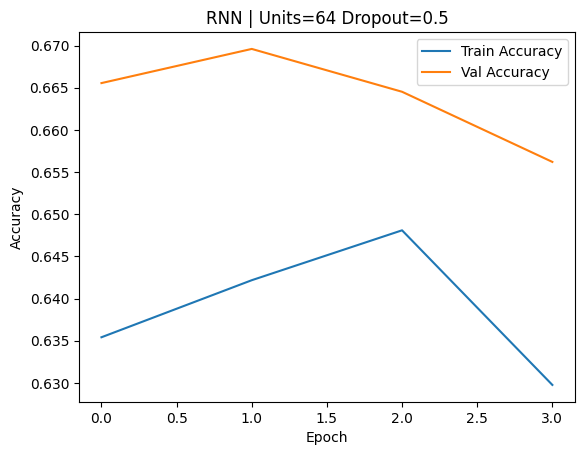


 Best RNN Model: {'units': 32, 'dropout': 0.3} | Val Accuracy: 0.7055
4344/4344 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.68      0.70     69829
           1       0.69      0.73      0.71     69158

    accuracy                           0.71    138987
   macro avg       0.71      0.71      0.71    138987
weighted avg       0.71      0.71      0.71    138987

Confusion Matrix:


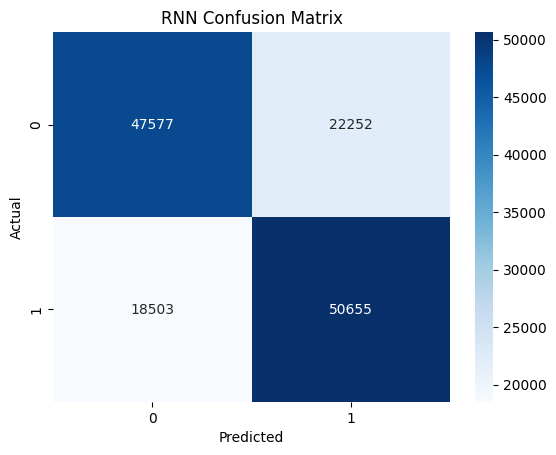


Training CNN with 32 units and 0.3 dropout...


c:\Applications\Social Media Sentiment Analysis\venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 198s 6ms/step - accuracy: 0.7341 - loss: 0.5337 - val_accuracy: 0.7755 - val_loss: 0.4736
Epoch 2/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 229s 7ms/step - accuracy: 0.7677 - loss: 0.4891 - val_accuracy: 0.7837 - val_loss: 0.4625
Epoch 3/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 212s 6ms/step - accuracy: 0.7731 - loss: 0.4808 - val_accuracy: 0.7836 - val_loss: 0.4619
Epoch 4/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 234s 7ms/step - accuracy: 0.7772 - loss: 0.4747 - val_accuracy: 0.7866 - val_loss: 0.4560
Epoch 5/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 215s 6ms/step - accuracy: 0.7806 - loss: 0.4698 - val_accuracy: 0.7892 - val_loss: 0.4548
Epoch 6/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 230s 7ms/step - accuracy: 0.7823 - loss: 0.4676 - val_accuracy: 0.7896 - val_loss: 0.4542
Epoch 7/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 215s 6ms/step - accuracy: 0.7834 - loss: 0.4649 - val_accuracy: 0.7910 - val_loss: 0.4545
Epoch 8/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 232s 7ms/step - ac

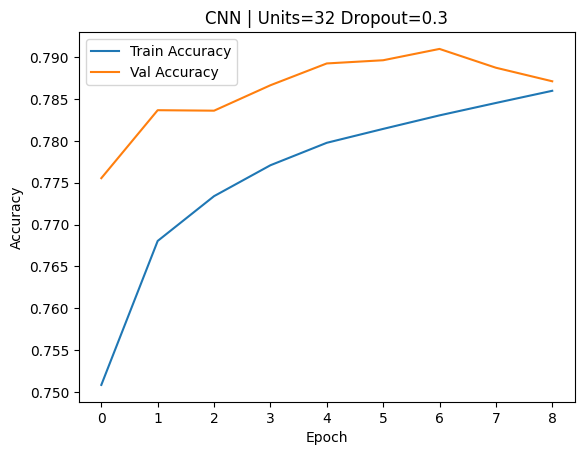


Training CNN with 32 units and 0.5 dropout...
Epoch 1/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 241s 7ms/step - accuracy: 0.7205 - loss: 0.5532 - val_accuracy: 0.7656 - val_loss: 0.4894
Epoch 2/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 232s 7ms/step - accuracy: 0.7545 - loss: 0.5110 - val_accuracy: 0.7736 - val_loss: 0.4759
Epoch 3/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 224s 6ms/step - accuracy: 0.7618 - loss: 0.5005 - val_accuracy: 0.7765 - val_loss: 0.4747
Epoch 4/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 231s 7ms/step - accuracy: 0.7649 - loss: 0.4962 - val_accuracy: 0.7807 - val_loss: 0.4754
Epoch 5/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 224s 6ms/step - accuracy: 0.7676 - loss: 0.4922 - val_accuracy: 0.7792 - val_loss: 0.4680
Epoch 6/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 233s 7ms/step - accuracy: 0.7706 - loss: 0.4890 - val_accuracy: 0.7852 - val_loss: 0.4636
Epoch 7/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 227s 7ms/step - accuracy: 0.7709 - loss: 0.4884 - val_accuracy: 0.7872 - val_loss: 0.4615
Epoch 8/10
3474

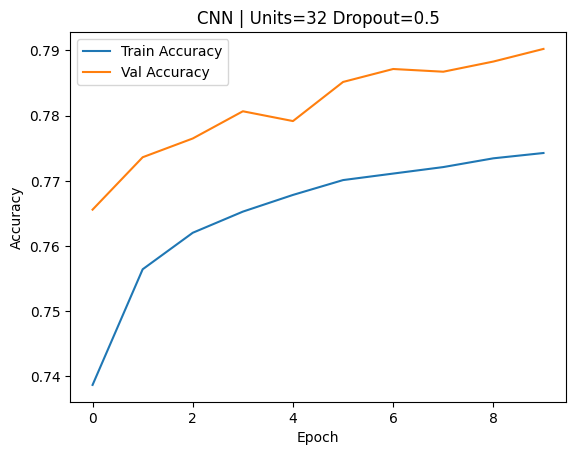


Training CNN with 64 units and 0.3 dropout...
Epoch 1/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 238s 7ms/step - accuracy: 0.7353 - loss: 0.5331 - val_accuracy: 0.7748 - val_loss: 0.4746
Epoch 2/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 232s 7ms/step - accuracy: 0.7663 - loss: 0.4906 - val_accuracy: 0.7737 - val_loss: 0.4748
Epoch 3/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 229s 7ms/step - accuracy: 0.7723 - loss: 0.4811 - val_accuracy: 0.7852 - val_loss: 0.4629
Epoch 4/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 236s 7ms/step - accuracy: 0.7769 - loss: 0.4759 - val_accuracy: 0.7860 - val_loss: 0.4589
Epoch 5/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 233s 7ms/step - accuracy: 0.7790 - loss: 0.4719 - val_accuracy: 0.7852 - val_loss: 0.4584
Epoch 6/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 236s 7ms/step - accuracy: 0.7812 - loss: 0.4685 - val_accuracy: 0.7861 - val_loss: 0.4555
Epoch 7/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 238s 7ms/step - accuracy: 0.7824 - loss: 0.4673 - val_accuracy: 0.7901 - val_loss: 0.4531
Epoch 8/10
3474

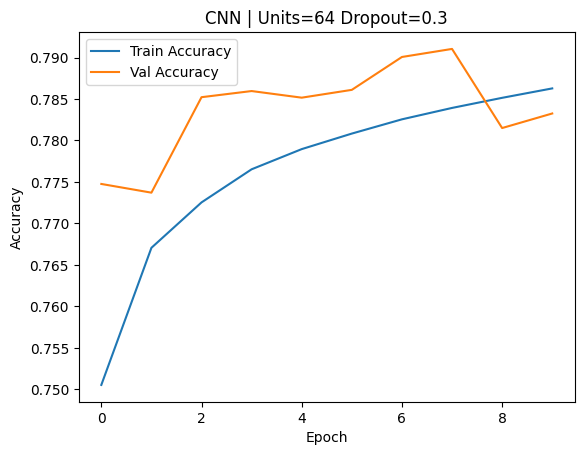


Training CNN with 64 units and 0.5 dropout...
Epoch 1/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 345s 9ms/step - accuracy: 0.7215 - loss: 0.5526 - val_accuracy: 0.7694 - val_loss: 0.4861
Epoch 2/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 300s 9ms/step - accuracy: 0.7556 - loss: 0.5104 - val_accuracy: 0.7778 - val_loss: 0.4756
Epoch 3/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 300s 9ms/step - accuracy: 0.7620 - loss: 0.5017 - val_accuracy: 0.7782 - val_loss: 0.4738
Epoch 4/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 300s 9ms/step - accuracy: 0.7651 - loss: 0.4953 - val_accuracy: 0.7818 - val_loss: 0.4668
Epoch 5/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 302s 9ms/step - accuracy: 0.7678 - loss: 0.4926 - val_accuracy: 0.7839 - val_loss: 0.4644
Epoch 6/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 301s 9ms/step - accuracy: 0.7691 - loss: 0.4900 - val_accuracy: 0.7865 - val_loss: 0.4640
Epoch 7/10
34747/34747 ━━━━━━━━━━━━━━━━━━━━ 301s 9ms/step - accuracy: 0.7710 - loss: 0.4878 - val_accuracy: 0.7871 - val_loss: 0.4624
Epoch 8/10
3474

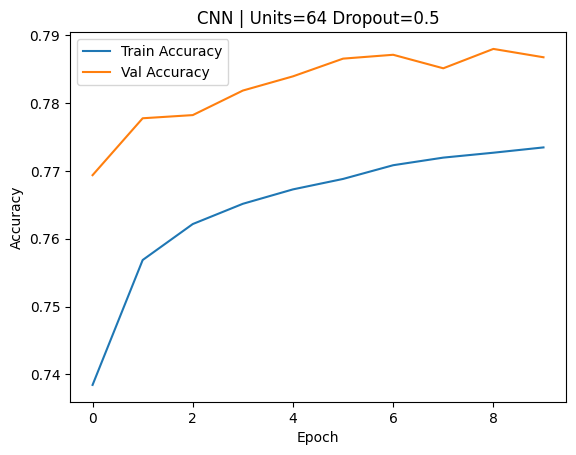


 Best CNN Model: {'units': 64, 'dropout': 0.3} | Val Accuracy: 0.7910
4344/4344 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79     69829
           1       0.79      0.79      0.79     69158

    accuracy                           0.79    138987
   macro avg       0.79      0.79      0.79    138987
weighted avg       0.79      0.79      0.79    138987

Confusion Matrix:


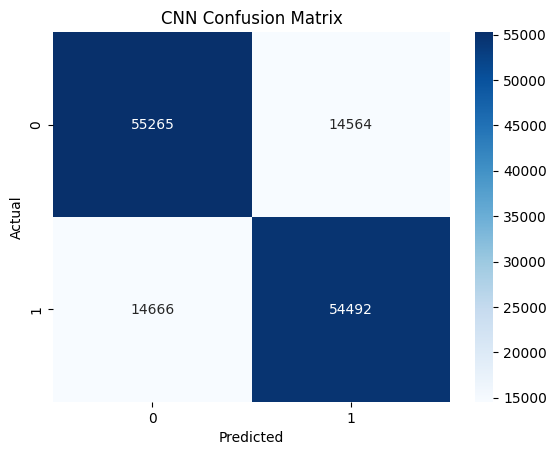

In [18]:
# Run all three models
for model_type in ['bilstm', 'rnn', 'cnn']:
    train_and_evaluate(model_type)

In [ ]:
best_model = tf.keras.load("best_bilstm_model_final.keras")

## DistilBERT Model

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from datasets import Dataset
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

c:\Applications\Social Media Sentiment Analysis\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#Load dataset
df = pd.read_csv("English_cleaned.csv")  
df = df[['normalized_tweet', 'target']]

In [ ]:
# Convert labels from [-1, 1] to [0, 1]
df["target"].replace(-1, 0, inplace=True)
df['target'] = df['target'].astype(int)

C:\Users\Lara\AppData\Local\Temp\ipykernel_27308\3095149900.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["target"].replace(-1, 0, inplace=True)


In [ ]:
# Train/val/test split
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['target'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df['target'], random_state=42)

In [ ]:
# Convert to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize_function(example):
    tokens = tokenizer(example["normalized_tweet"], padding="max_length", truncation=True, max_length=128)
    tokens["labels"] = example["target"]
    return tokens

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 208480/208480 [00:11<00:00, 18018.55 examples/s]


In [ ]:
def convert_to_tf_dataset(hf_dataset, batch_size=16):  # Add batch_size parameter with default value
    return hf_dataset.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["labels"],
        shuffle=True,
        batch_size=batch_size, 
    )

In [ ]:
def get_balanced_sample(dataset, sample_size, seed=42):
    df = dataset.to_pandas()

    # Perform stratified sampling
    sample_df = df.groupby('target', group_keys=False).apply(
        lambda x: x.sample(
            min(len(x), sample_size // df['target'].nunique()), 
            random_state=seed
        )
    )

    return Dataset.from_pandas(sample_df.reset_index(drop=True))

train_sample = get_balanced_sample(train_dataset, 20000)
val_sample = get_balanced_sample(val_dataset, 5000)

C:\Users\Lara\AppData\Local\Temp\ipykernel_8392\1578741037.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby('target', group_keys=False).apply(
C:\Users\Lara\AppData\Local\Temp\ipykernel_8392\1578741037.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby('target', group_keys=False).apply(


In [ ]:
def objective(trial):
    # Get hyperparameters
    batch_size = trial.suggest_categorical("batch_size", [16, 32])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
    epochs = trial.suggest_int("num_train_epochs", 2, 5)
    
    # Create datasets with current batch_size
    tf_train = convert_to_tf_dataset(train_sample, batch_size)
    tf_val = convert_to_tf_dataset(val_sample, batch_size)
    
    model = TFDistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", 
        num_labels=2
    )
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        weight_decay=weight_decay
    )
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
    )
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
    
    history = model.fit(
        tf_train,
        validation_data=tf_val,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    best_val_loss = min(history.history['val_loss'])
    
    # Store history in trial user attributes
    trial.set_user_attr("history", history.history)  
    
    import joblib
    study = joblib.load('study.pkl')
    
    try:
        if not study.best_trial or best_val_loss < study.best_value:
            model.save_pretrained('./best_model')
    except ValueError:  # No completed trials yet
        model.save_pretrained('./best_model')
    
    return best_val_loss

In [ ]:
import joblib

# Run hyperparameter search
print("Starting hyperparameter optimization...")
study = joblib.load('study.pkl')
histories = {} 

def callback(study, trial):
    if 'history' in trial.user_attrs:  # Add safety check
        histories[trial.number] = trial.user_attrs['history']

study.optimize(objective, n_trials=4, callbacks=[callback])

# Save the updated study
joblib.dump(study, 'study_updated.pkl')

print("\nHyperparameter search complete!")
print(f"Best trial: {study.best_trial.number}")
print(f"Best validation loss: {study.best_trial.value:.4f}")
print("Best parameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

Starting hyperparameter optimization...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/4
1250/1250 [==============================] - 2701s 2s/step - loss: 0.4728 - accuracy: 0.7730 - val_loss: 0.4236 - val_accuracy: 0.8044
Epoch 2/4
1250/1250 [==============================] - 2691s 2s/step - loss: 0.3496 - accuracy: 0.8485 - val_loss: 0.4303 - val_accuracy: 0.8124
Epoch 3/4
1250/1250 [==============================] - 2695s 2s/step - loss: 0.2233 - accuracy: 0.9115 - val_loss: 0.5232 - val_accuracy: 0.7970


[I 2025-05-11 07:11:15,965] Trial 1 finished with value: 0.4235532581806183 and parameters: {'batch_size': 16, 'learning_rate': 1.8510968716949187e-05, 'weight_decay': 0.21911484845497778, 'num_train_epochs': 4}. Best is trial 1 with value: 0.4235532581806183.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification 

Epoch 1/4
1250/1250 [==============================] - 2760s 2s/step - loss: 0.4736 - accuracy: 0.7733 - val_loss: 0.4305 - val_accuracy: 0.8020
Epoch 2/4
1250/1250 [==============================] - 2733s 2s/step - loss: 0.3448 - accuracy: 0.8515 - val_loss: 0.4661 - val_accuracy: 0.8058
Epoch 3/4
1250/1250 [==============================] - 2699s 2s/step - loss: 0.2109 - accuracy: 0.9143 - val_loss: 0.5456 - val_accuracy: 0.8032


[I 2025-05-11 09:27:49,527] Trial 2 finished with value: 0.4304724633693695 and parameters: {'batch_size': 16, 'learning_rate': 2.114353178660403e-05, 'weight_decay': 0.0937258046461137, 'num_train_epochs': 4}. Best is trial 1 with value: 0.4235532581806183.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification mo

Epoch 1/2
625/625 [==============================] - 2509s 4s/step - loss: 0.4767 - accuracy: 0.7756 - val_loss: 0.4303 - val_accuracy: 0.8046
Epoch 2/2
625/625 [==============================] - 2508s 4s/step - loss: 0.3361 - accuracy: 0.8579 - val_loss: 0.4516 - val_accuracy: 0.8032


[I 2025-05-11 10:51:29,040] Trial 3 finished with value: 0.43031612038612366 and parameters: {'batch_size': 32, 'learning_rate': 3.831982067283304e-05, 'weight_decay': 0.034550923068696435, 'num_train_epochs': 2}. Best is trial 1 with value: 0.4235532581806183.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification

Epoch 1/5
625/625 [==============================] - 2590s 4s/step - loss: 0.4781 - accuracy: 0.7717 - val_loss: 0.4303 - val_accuracy: 0.7964
Epoch 2/5
625/625 [==============================] - 2518s 4s/step - loss: 0.3561 - accuracy: 0.8464 - val_loss: 0.4486 - val_accuracy: 0.8088
Epoch 3/5
625/625 [==============================] - 2505s 4s/step - loss: 0.2390 - accuracy: 0.9050 - val_loss: 0.5258 - val_accuracy: 0.8060


[I 2025-05-11 12:58:23,668] Trial 4 finished with value: 0.43029090762138367 and parameters: {'batch_size': 32, 'learning_rate': 2.147214762292175e-05, 'weight_decay': 0.04079285534046717, 'num_train_epochs': 5}. Best is trial 1 with value: 0.4235532581806183.



Hyperparameter search complete!
Best trial: 1
Best validation loss: 0.4236
Best parameters:
  batch_size: 16
  learning_rate: 1.8510968716949187e-05
  weight_decay: 0.21911484845497778
  num_train_epochs: 4


In [ ]:
joblib.dump(study, 'study.pkl')  # Save immediately

['study.pkl']


Plotting training history from best trial...


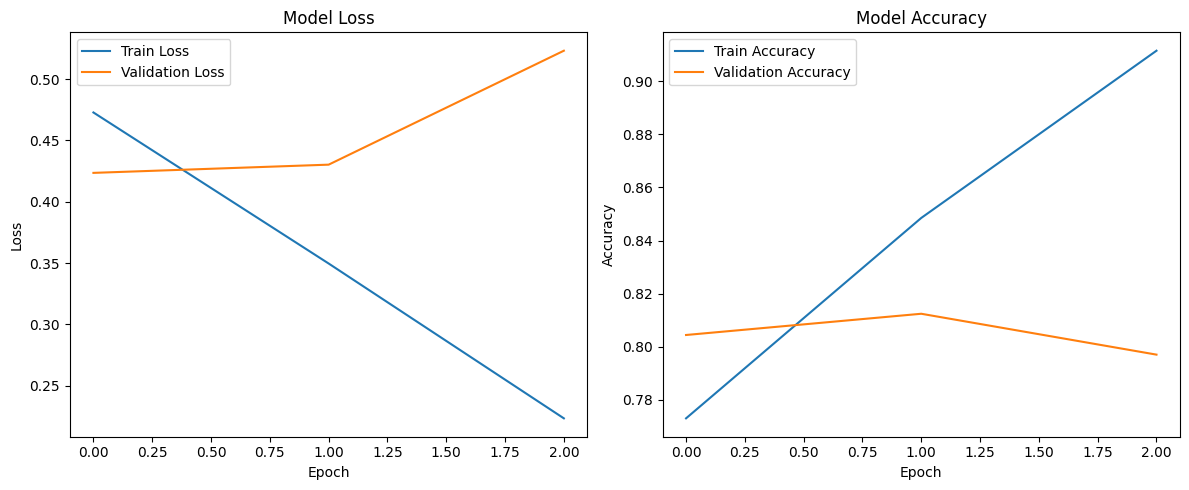

In [ ]:
# Load the training history from the best trial
print("\nPlotting training history from best trial...")

# Get the best trial's number
best_trial_num = study.best_trial.number
best_history = histories[study.best_trial.number]

plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(best_history['loss'], label='Train Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(best_history['accuracy'], label='Train Accuracy')
plt.plot(best_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
final_train_sample = get_balanced_sample(train_dataset, 200000)
final_val_sample = get_balanced_sample(val_dataset, 100000)

C:\Users\Lara\AppData\Local\Temp\ipykernel_8392\1578741037.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby('target', group_keys=False).apply(
C:\Users\Lara\AppData\Local\Temp\ipykernel_8392\1578741037.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby('target', group_keys=False).apply(


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/4
3125/3125 [==============================] - ETA: 0s - loss: 0.4086 - accuracy: 0.8134
New best validation accuracy: 0.8309


c:\Applications\Social Media Sentiment Analysis\venv\lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Model saved to best_model.keras
3125/3125 [==============================] - 28472s 9s/step - loss: 0.4086 - accuracy: 0.8134 - val_loss: 0.3830 - val_accuracy: 0.8309
Epoch 2/4
3125/3125 [==============================] - ETA: 0s - loss: 0.3381 - accuracy: 0.8519
New best validation accuracy: 0.8368
Model saved to best_model.keras
3125/3125 [==============================] - 27613s 9s/step - loss: 0.3381 - accuracy: 0.8519 - val_loss: 0.3740 - val_accuracy: 0.8368
Epoch 3/4
3125/3125 [==============================] - 27375s 9s/step - loss: 0.2762 - accuracy: 0.8831 - val_loss: 0.3910 - val_accuracy: 0.8338
Epoch 4/4
3125/3125 [==============================] - 27375s 9s/step - loss: 0.2092 - accuracy: 0.9144 - val_loss: 0.4665 - val_accuracy: 0.8266


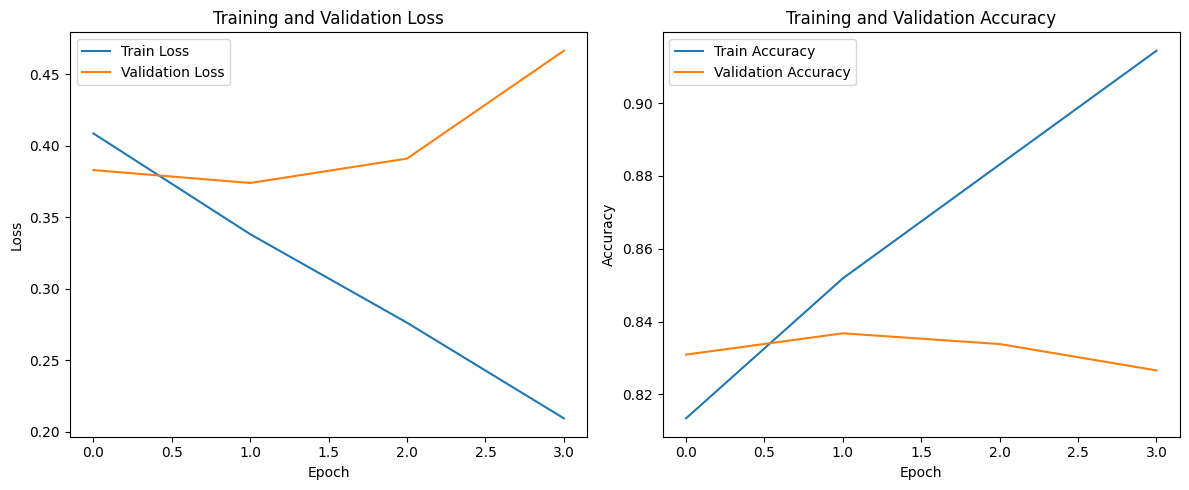

In [ ]:
def train_with_accuracy_checkpoints():
    # Load best parameters from Optuna study
    best_params = study.best_trial.params
    
    # Prepare datasets
    tf_train = convert_to_tf_dataset(final_train_sample, 64)
    tf_val = convert_to_tf_dataset(final_val_sample, 64)
    
    # Initialize model
    model = TFDistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=2
    )
    
    # Configure optimizer
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    # Track best accuracy
    best_val_accuracy = 0
    best_model_path = 'best_model.keras'
    
    # Custom callback to save on accuracy improvement
    class AccuracyCheckpoint(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            nonlocal best_val_accuracy
            current_acc = logs['val_accuracy']
            if current_acc > best_val_accuracy:
                best_val_accuracy = current_acc
                print(f"\nNew best validation accuracy: {best_val_accuracy:.4f}")
                # Save full model
                tf.keras.models.save_model(model, best_model_path)
                print(f"Model saved to {best_model_path}")
    
    # Training callbacks
    callbacks = [
        AccuracyCheckpoint(),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=2,
            mode='max',
            restore_best_weights=True
        )
    ]
    
    # Train model
    history = model.fit(
        tf_train,
        validation_data=tf_val,
        epochs=best_params['num_train_epochs'],
        callbacks=callbacks,
        verbose=1
    )
    
    # Plot training history
    plot_training_history(history)
    
    return model, history

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Run training
final_model, training_history = train_with_accuracy_checkpoints()

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# Load best model
print("\nLoading best model...")
best_model = TFDistilBertForSequenceClassification.from_pretrained('./best_model')
print("\nLoading tokenizer...")
tokenizer = DistilBertTokenizer.from_pretrained('./best_model')


Loading best model...



Some layers from the model checkpoint at ./best_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_219']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./best_model and are newly initialized: ['dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Loading tokenizer...


In [ ]:
# Prepare test set with best batch size
best_batch_size = study.best_trial.params['batch_size']
tf_test_dataset = convert_to_tf_dataset(test_dataset, 64)

c:\Applications\Social Media Sentiment Analysis\venv\lib\site-packages\datasets\arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
def evaluate_model_metrics(model, test_dataset, batch_size=1024):
    """Evaluate the model and compute precision, recall, F1 score"""
    import time
    from datetime import timedelta
    
    # Convert to TF dataset with larger batch size
    tf_test = convert_to_tf_dataset(test_dataset, batch_size)
    
    # Predictions
    all_predictions = []
    all_labels = []
    
    # Count total batches for progress reporting
    total_samples = len(test_dataset)
    total_batches = int(np.ceil(total_samples / batch_size))
    
    print(f"Starting evaluation on {total_samples} samples using batch size {batch_size}")
    print(f"Total batches to process: {total_batches}")
    
    # Timing variables
    start_time = time.time()
    batch_times = []
    
    # Get predictions and true labels
    for i, batch in enumerate(tf_test):
        batch_start = time.time()
        
        inputs = {
            'input_ids': batch[0]['input_ids'],
            'attention_mask': batch[0]['attention_mask']
        }
        labels = batch[1].numpy()
        
        # Disable verbose output from model.predict
        outputs = model.predict(inputs, verbose=0)
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs
        
        # For SparseCategoricalCrossentropy, get class with highest probability
        predictions = np.argmax(logits, axis=1)
        
        all_predictions.extend(predictions)
        all_labels.extend(labels)
        
        # Calculate timing and ETA
        batch_end = time.time()
        batch_duration = batch_end - batch_start
        batch_times.append(batch_duration)
        
        # Only keep the last 50 batch times for moving average
        if len(batch_times) > 50:
            batch_times.pop(0)
        
        avg_time_per_batch = sum(batch_times) / len(batch_times)
        elapsed_time = batch_end - start_time
        estimated_total_time = avg_time_per_batch * total_batches
        remaining_time = estimated_total_time - elapsed_time
        
        # Show progress every 50 batches
        if i % 50 == 0 or i == total_batches - 1:
            eta_str = str(timedelta(seconds=int(remaining_time)))
            elapsed_str = str(timedelta(seconds=int(elapsed_time)))
            print(f"Batch {i+1}/{total_batches} ({(i+1)/total_batches*100:.1f}%) | "
                  f"Elapsed: {elapsed_str} | ETA: {eta_str} | "
                  f"Avg batch: {avg_time_per_batch:.2f}s")
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    
    # Print confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    from sklearn.metrics import roc_auc_score, roc_curve

    # AUC Score
    auc = roc_auc_score(all_labels, all_predictions)
    print(f"AUC-ROC Score: {auc:.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    from sklearn.metrics import classification_report
    print(classification_report(all_labels, all_predictions, digits=4))

    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'confusion_matrix': cm
    }

c:\Applications\Social Media Sentiment Analysis\venv\lib\site-packages\datasets\arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


Starting evaluation on 208480 samples using batch size 1024
Total batches to process: 204
Batch 1/204 (0.5%) | Elapsed: 0:00:37 | ETA: 2:05:18 | Avg batch: 37.04s
Batch 51/204 (25.0%) | Elapsed: 0:30:36 | ETA: 1:31:43 | Avg batch: 35.98s
Batch 101/204 (49.5%) | Elapsed: 1:00:31 | ETA: 1:01:35 | Avg batch: 35.92s
Batch 151/204 (74.0%) | Elapsed: 1:30:23 | ETA: 0:31:25 | Avg batch: 35.83s
Batch 201/204 (98.5%) | Elapsed: 2:00:13 | ETA: 0:01:29 | Avg batch: 35.80s
Batch 204/204 (100.0%) | Elapsed: 2:01:45 | ETA: -1 day, 23:58:51 | Avg batch: 35.47s
Accuracy: 0.8024
Precision: 0.7726
Recall: 0.8502
F1 Score: 0.8096

Confusion Matrix:
[[79722 25766]
 [15431 87561]]


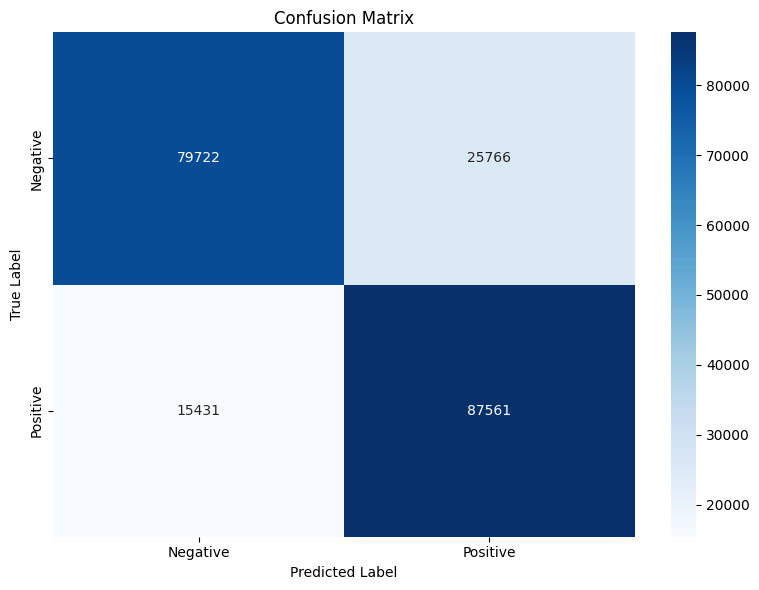

AUC-ROC Score: 0.8030


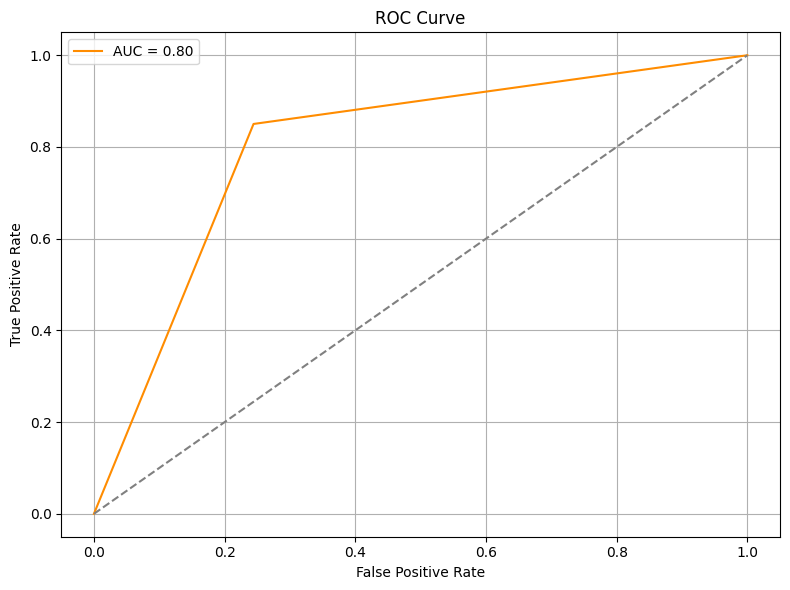

              precision    recall  f1-score   support

           0     0.8378    0.7557    0.7947    105488
           1     0.7726    0.8502    0.8096    102992

    accuracy                         0.8024    208480
   macro avg     0.8052    0.8030    0.8021    208480
weighted avg     0.8056    0.8024    0.8020    208480



In [ ]:
metrics = evaluate_model_metrics(best_model, test_dataset)

In [ ]:
# Print classification metrics with proper formatting
print(f"""
    Classification Metrics:
    ----------------------
    Accuracy:  {metrics['accuracy']:.4f}
    Precision: {metrics['precision']:.4f}
    Recall:    {metrics['recall']:.4f}
    F1 Score:  {metrics['f1']:.4f}
    """)


    Classification Metrics:
    ----------------------
    Accuracy:  0.8024
    Precision: 0.7726
    Recall:    0.8502
    F1 Score:  0.8096
    


In [ ]:
tokenizer.save_pretrained('./best_model')

('./best_model\\tokenizer_config.json',
 './best_model\\special_tokens_map.json',
 './best_model\\vocab.txt',
 './best_model\\added_tokens.json',
 './best_model\\tokenizer.json')

In [ ]:
def predict_sentences(model, tokenizer, sentences, neutral_threshold=0.15):  # Increased neutral threshold
    all_results = []
    
    for sentence in sentences:
        # Skip empty strings
        if not sentence.strip():
            all_results.append({
                'Sentence': sentence,
                'Sentiment': 'Neutral',
                'Probability': 0.5,
                'Confidence': 0.0,
                'Predicted Class': -1
            })
            continue
            
        inputs = tokenizer(
            sentence,
            truncation=True,
            padding=True,
            max_length=128,
            return_tensors='tf'
        )
        
        # Silent prediction
        outputs = model.predict(inputs, verbose=0)
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs
        
        # Get probabilities
        probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]
        predicted_class = np.argmax(probabilities)
        confidence = probabilities[predicted_class]
        
        # Sentiment determination with wider neutral range
        pos_prob = probabilities[1]
        neg_prob = probabilities[0]
        if 0.4 <= pos_prob <= 0.6:
            label = "Neutral"
        elif predicted_class == 1:
            label = "Positive"
        else:
            label = "Negative"

        all_results.append({
            'Sentence': sentence,
            'Sentiment': label,
            'Pos. Probability': float(pos_prob),
            'Neg. Probability': float(neg_prob),
            'Confidence': float(confidence),
            'Predicted Class': int(predicted_class)
        })
    
    return pd.DataFrame(all_results)

In [ ]:
sample_sentences = [
    # Strong positive
    "I absolutely loved this product!",
    "Amazing! Totally worth it!",
    "Five stars without hesitation",
    "this app is a game-changer! It's intuitive, powerful, and has everything I need in one place.",
    "Best purchase I've made all year!",
    "Exceeded all my expectations - phenomenal quality!",
    "Worth every penny and then some!",
    "I'm blown away by how good this is!",
    "Perfect in every way imaginable!",
    "Can't recommend this highly enough!",
    
    # Moderate positive
    "Really good product overall",
    "Definitely worth trying out",
    "Pleasantly surprised by the quality",
    "Does exactly what it promises",
    "Solid performance for the price",
    "I'd buy this again",
    "Good value for money",
    "Reliable and gets the job done",
    "Better than I expected",
    "No major complaints",
    
    # Neutral/mixed
    "It was okay, nothing special.",
    "I wouldn't buy it again, but it was decent.",
    "Average quality for the price. I've seen better but I've seen worse.", 
    "Not bad, not great",
    "Does the job, but barely",
    "Mediocre at best",
    "Neither impressed nor disappointed",
    "It exists... that's about it",
    "Exactly what you'd expect, nothing more",
    "Fine, I guess",
    
    # Moderate negative
    "Terrible service, very disappointed.", 
    "The product arrived damaged",
    "Not worth the money",
    "Poor quality materials",
    "Wouldn't recommend to anyone",
    "Frustrating to use",
    "Subpar experience overall",
    "Much worse than advertised",
    "Lasted less than a week",
    "Complete waste of time",
    
    # Strong negative
    "This is the worst experience I've had.",
    "The product arrived broken and the company refused to refund or replace it. Scam!", 
    "Save your money! It stopped working after 2 days and support ignored my emails.",
    "A total rip-off. nothing like the description or photos.",
    "Absolute garbage - don't fall for it!",
    "Worst purchase decision of my life",
    "Dangerously defective product",
    "Fraudulent company with zero ethics",
    "Literally fell apart on first use",
    "Should be illegal to sell this junk"
]

# Add some edge cases
edge_cases = [
    "",  # empty string
    " ",  # whitespace
    "Good and bad",  # mixed sentiment
    "It's not not good",  # double negative
    "Meh.",  # informal neutral
    "LOL this is ridiculous"  # sarcasm?
]

sample_sentences.extend(edge_cases)

# Run predictions
results = predict_sentences(best_model, tokenizer, sample_sentences)

# Display results with formatting
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 60)
results.head(100)

,Sentence,Sentiment,Pos. Probability,Neg. Probability,Confidence,Predicted Class,Probability
0,I absolutely loved this product!,Positive,0.954008,0.045992,0.954008,1,NaN
1,Amazing! Totally worth it!,Positive,0.970371,0.029629,0.970371,1,NaN
2,Five stars without hesitation,Positive,0.932725,0.067275,0.932725,1,NaN
3,"this app is a game-changer! It's intuitive, powerful, an...",Positive,0.911092,0.088908,0.911092,1,NaN
4,Best purchase I've made all year!,Positive,0.942820,0.057180,0.942820,1,NaN
5,Exceeded all my expectations - phenomenal quality!,Positive,0.791656,0.208344,0.791656,1,NaN
6,Worth every penny and then some!,Positive,0.884502,0.115498,0.884502,1,NaN
7,I'm blown away by how good this is!,Negative,0.250239,0.749761,0.749761,0,NaN
8,Perfect in every way imaginable!,Positive,0.949161,0.050839,0.949161,1,NaN
9,Can't recommend this highly enough!,Negative,0.369496,0.630504,0.630504,0,NaN


In [ ]:
sample_texts = [
    "I wouldn't recommend this to anyone",
    "This product works great and exceeded my expectations!",
    "Terrible quality, would not recommend to anyone.",
    "It was okay, nothing special but not bad either.",
    "Absolutely loved it! Will buy again.",
    "Not what I expected, pretty disappointing.",
    "Fantastic service and very friendly staff!",
    "I have no complaints, everything was fine.",
    "The worst experience I've had in a long time.",
    "It was not bad at all, quite enjoyable actually.",
    "Decent, but could've been better.",
    "I can't say I hated it, but I wouldn't do it again.",
    "Great value for the price!",
    "The packaging was poor but the product was excellent.",
    "Meh. Just average. Nothing stood out.",
    "Totally exceeded my expectations.",
    "Wouldn't say it's perfect, but it's close.",
    "Disgusting. Would never touch this again.",
    "Not impressed, but not the worst either.",
    "Superb quality and lightning-fast delivery!"
]
# Run predictions
results = predict_sentences(best_model, tokenizer, sample_texts)

# Display results with formatting
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 60)
results.head(100)

,Sentence,Sentiment,Pos. Probability,Neg. Probability,Confidence,Predicted Class
0,I wouldn't recommend this to anyone,Positive,0.711780,0.288220,0.711780,1
1,This product works great and exceeded my expectations!,Positive,0.831477,0.168523,0.831477,1
2,"Terrible quality, would not recommend to anyone.",Negative,0.333439,0.666561,0.666561,0
3,"It was okay, nothing special but not bad either.",Positive,0.848707,0.151293,0.848707,1
4,Absolutely loved it! Will buy again.,Positive,0.946384,0.053616,0.946384,1
5,"Not what I expected, pretty disappointing.",Negative,0.087479,0.912521,0.912521,0
6,Fantastic service and very friendly staff!,Positive,0.972114,0.027886,0.972114,1
7,"I have no complaints, everything was fine.",Positive,0.885784,0.114216,0.885784,1
8,The worst experience I've had in a long time.,Negative,0.071872,0.928128,0.928128,0
9,"It was not bad at all, quite enjoyable actually.",Positive,0.932458,0.067542,0.932458,1
